This is run by ResNet like architecture with first pooling layer adjustments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

# print(bhArray.shape)
# print(sphArray.shape)

In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [5]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [6]:
#Sjekke om device GPU er på
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
#Transofrm from numpy array to torch
trainData = torch.from_numpy(trainData).permute(0,3,1,2)
testData = torch.from_numpy(testData).permute(0,3,1,2)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#Transform data data to dataloader
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [11]:
from torchsummary import summary
import nnmodel

model = nnmodel.ResSymmetricNet(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, input_size=(3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,728
       BatchNorm2d-2           [-1, 64, 50, 50]             128
            Conv2d-3           [-1, 64, 50, 50]           1,728
       BatchNorm2d-4           [-1, 64, 50, 50]             128
            Conv2d-5           [-1, 64, 50, 50]           1,728
       BatchNorm2d-6           [-1, 64, 50, 50]             128
            Conv2d-7           [-1, 64, 50, 50]           1,728
       BatchNorm2d-8           [-1, 64, 50, 50]             128
         AvgPool2d-9           [-1, 64, 25, 25]               0
        AvgPool2d-10           [-1, 64, 25, 25]               0
        AvgPool2d-11           [-1, 64, 25, 25]               0
        AvgPool2d-12           [-1, 64, 25, 25]               0
          Dropout-13           [-1, 64, 25, 25]               0
           Conv2d-14          [-1, 128,

Epoch: 0/15
Train Loss: 0.3545, Train Accuracy: 86.56%
Test Loss: 0.2936, Test Accuracy: 87.31%
Epoch: 1/15
Train Loss: 0.2594, Train Accuracy: 89.88%
Test Loss: 0.2758, Test Accuracy: 88.61%
Epoch: 2/15
Train Loss: 0.2385, Train Accuracy: 90.77%
Test Loss: 0.2206, Test Accuracy: 90.69%
Epoch: 3/15
Train Loss: 0.2230, Train Accuracy: 91.39%
Test Loss: 0.5462, Test Accuracy: 83.84%
Epoch: 4/15
Train Loss: 0.2137, Train Accuracy: 91.85%
Test Loss: 0.3153, Test Accuracy: 87.00%
Epoch: 5/15
Train Loss: 0.2130, Train Accuracy: 91.90%
Test Loss: 0.4100, Test Accuracy: 86.07%
Epoch: 6/15
Train Loss: 0.2056, Train Accuracy: 92.49%
Test Loss: 0.2525, Test Accuracy: 88.69%
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 7/15
Train Loss: 0.1858, Train Accuracy: 92.76%
Test Loss: 0.3685, Test Accuracy: 85.48%
Epoch: 8/15
Train Loss: 0.1808, Train Accuracy: 93.26%
Test Loss: 0.3079, Test Accuracy: 86.87%
Epoch: 9/15
Train Loss: 0.1754, Train Accuracy: 93.00%
Test Loss: 0.3680, 

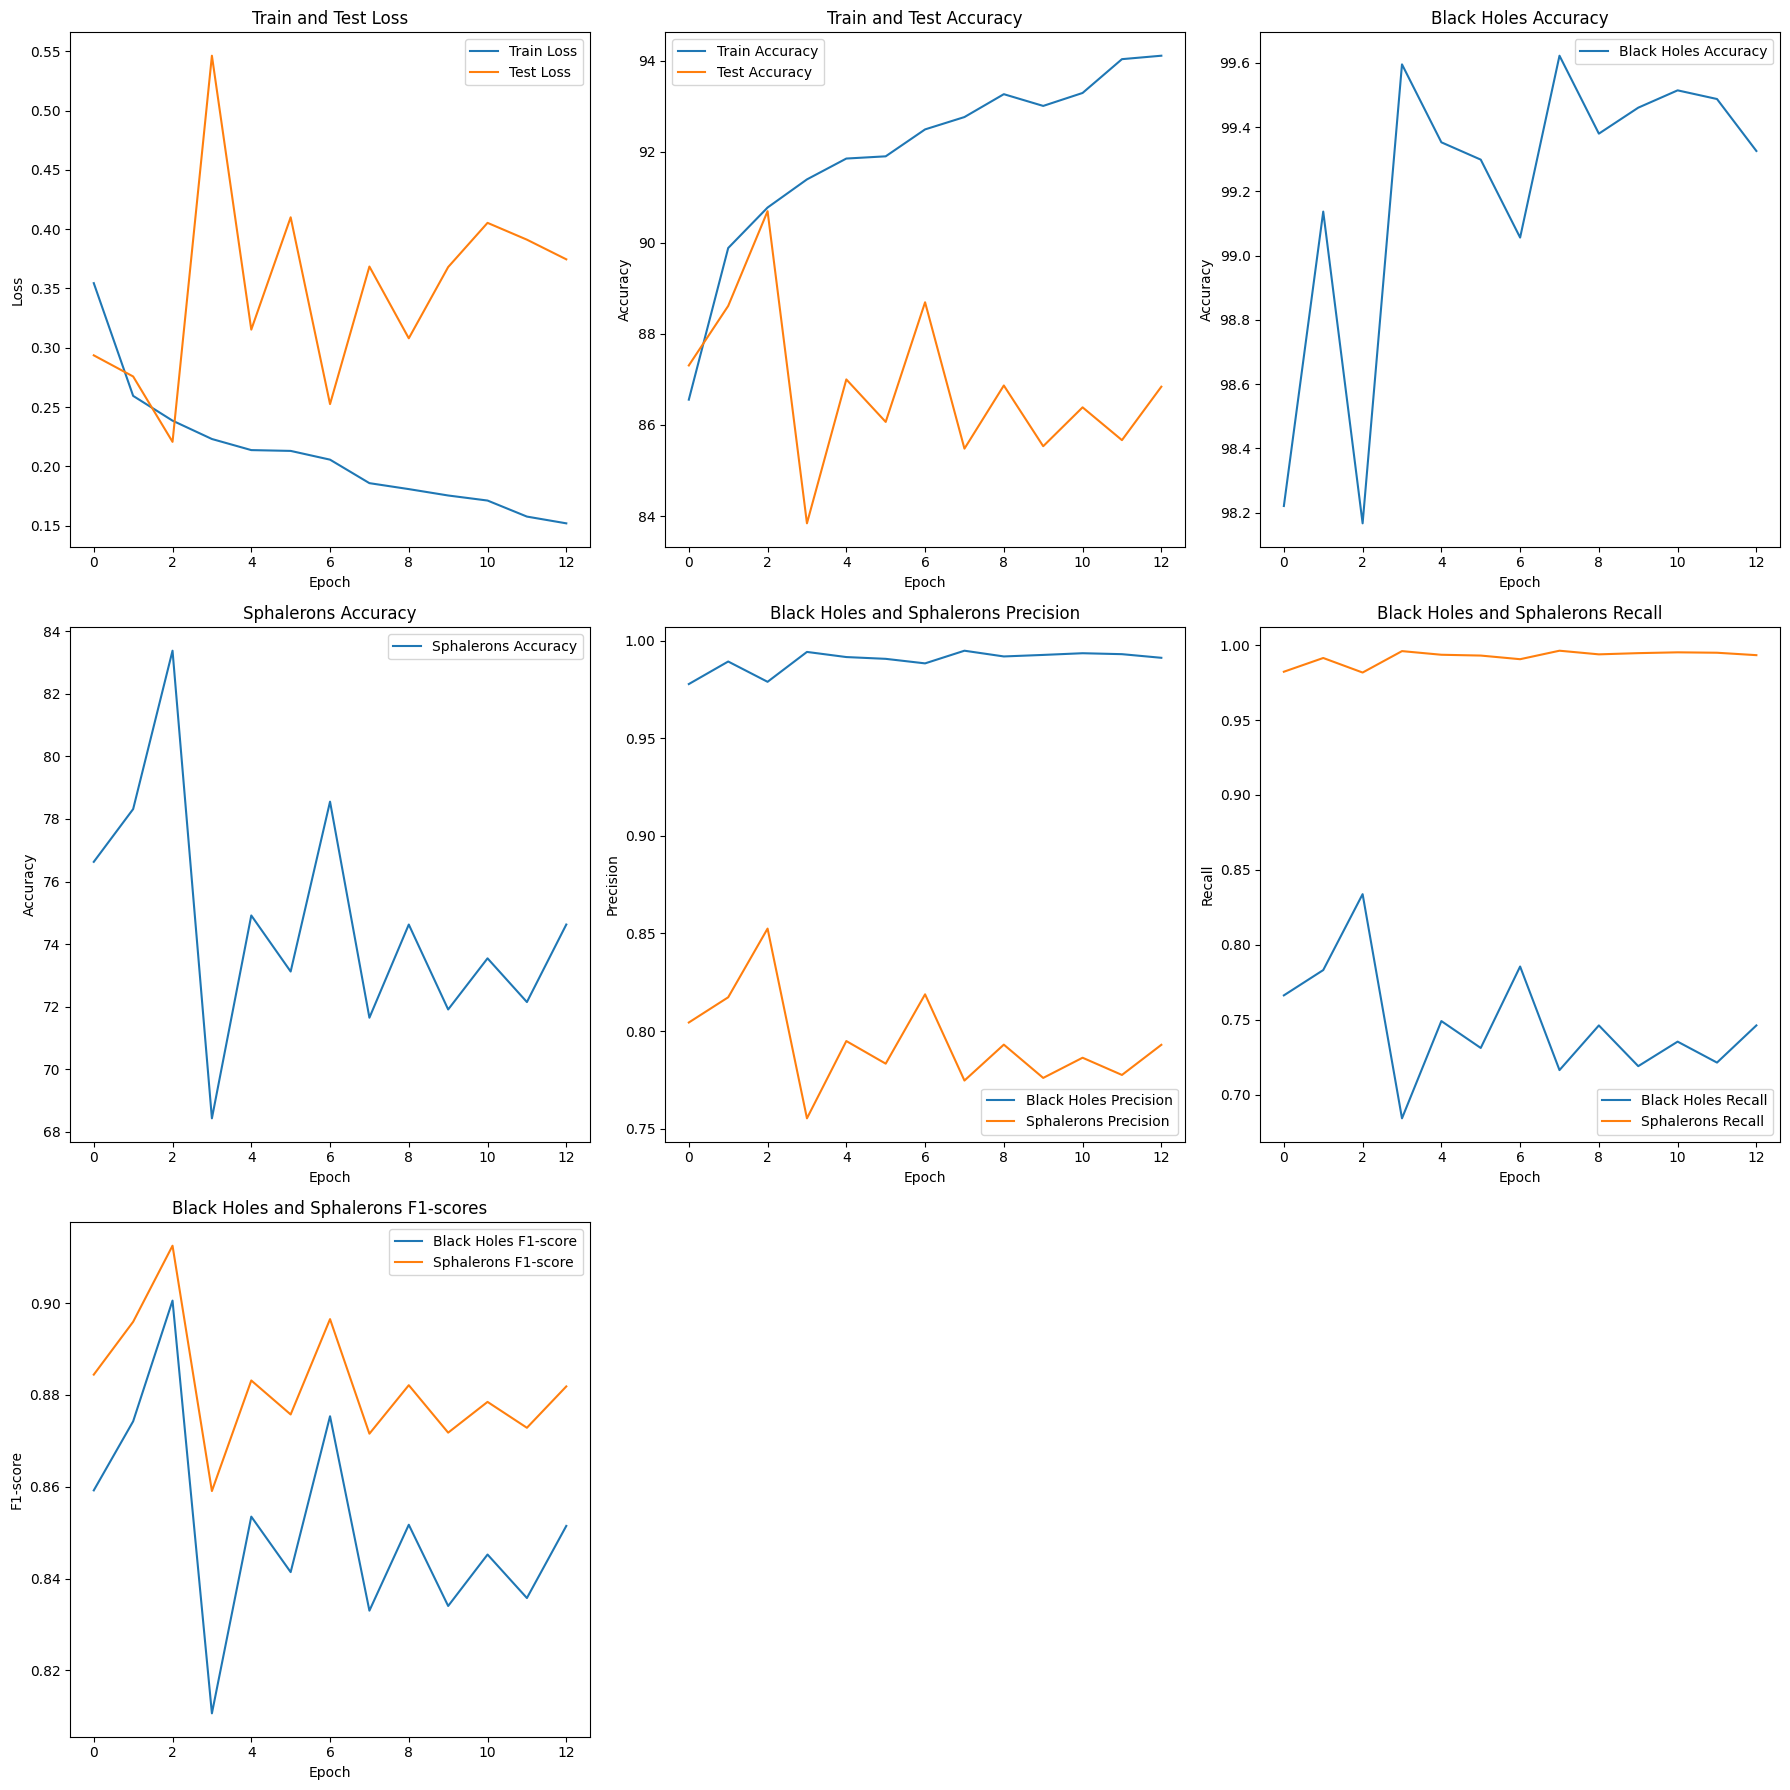

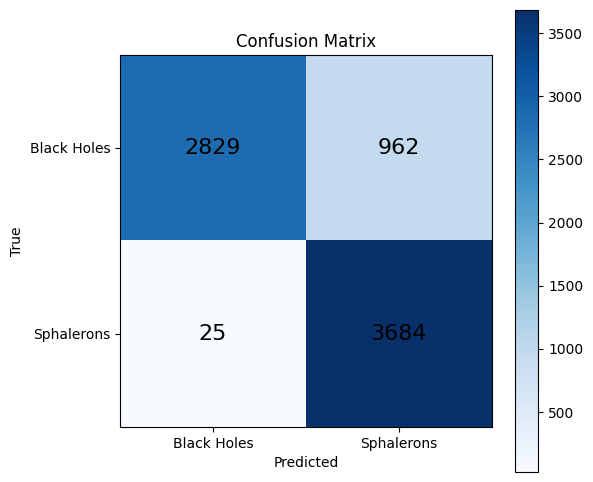

In [13]:
import trainer
# Set the learning rate and number of epochs
n_epochs = 15

# Create the model
model = nnmodel.ResSymmetricNet(0.5).to(device)

# Set up the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)

# Train the model
trainer.train(model, trainLoader, testLoader, optimizer, criterion, n_epochs, scheduler = scheduler, early_stopping_patience = 10)